In [1]:
# Code imports
from lib.opt_types import *
from lib.utils import *

# Image inpainting with proximal methods - 30 points

Image in-painting consists of reconstructing the missing parts of an image from a given incomplete image.

By exploiting some prior knowledge on the image, it is possible to in-paint images that have a large portion of their pixels missing. In this part of the homework, we are going to study different methods to achieve this goal.

We consider a subsampled image $\mathbf{b} = \mathbf{P}_{\Omega} \mathbf{x}$, where $\mathbf{P}_{\Omega} \in \mathbb{R}^{n \times p}$ is an operator that selects only few, $n \ll p := m^2$, pixels from the vectorized image $\mathbf{x} \in \mathbb{R}^p$. Our goal is to reconstruct the original image $\mathbf{x}$.

### Prior knowledge

Image inpainting is impossible without having some prior knowledge on the structure of the true image $\mathbf{x}$. 

We will explore and compare the following prior assumptions we can make on the true image: 
>  **Assumption**: There exists a orthonormal basis $\mathbf{W} \in \mathbb{R}^{p\times p}$ such that $\mathbf{x}$ can be sparsely represented in that basis, i.e, $\mathbf{W} \mathbf{x}$ is a vector with few non-zero coefficients. Said more formally, this assumption states that there exists $\mathbf{\alpha} \in \mathbb{R}^p$ with small $\ell_1$ norm such that $\mathbf{x} = \mathbf{W}^\top\alpha$. We assume that this basis is known and corresponds to the _wavelet basis_. Under this assumption, the reconstruction problem corresponds to solving the following optimization problem:
$$
    \min_{\mathbf{\alpha} \in \mathbb{R}^{p}} \underbrace{ \frac{1}{2}\|\mathbf{b} - \mathbf{P}_{\Omega} \mathbf{W}^T\mathbf{\alpha} \|_2^2}_{f_{\ell_1}(\mathbf{\alpha})} + \underbrace{\lambda_{\ell_1} \|\mathbf{\alpha}\|_1}_{g_{\ell_1}(\mathbf{\alpha})},
$$
where $\lambda_{\ell_1}$ is a coefficient we will need to choose.



# PART 1: Optimizing with an $\ell_1$ norm regularization

The optimization problem we are looking to solve have an objective function of the form:
$$
	 f(\mathbf{x}) + g(\mathbf{x}).
$$

These types of objectives are referred to as _composite objectives_ where one term, $f$, is smooth and differentiable and the other term $g$ is non-differentiable.

---

## Code structure:

Recall that we have been working with the `Function` type so far. We will augment this type to represent functions that are not differentiable:

- Given a `Function` `g` you can obtain a subgradient at a point `x` by calling `g.subgrad(x)`.

Moreover, since we are dealing with _composite_ problems with a an objective function that can be written `f + lambda*g`, we define the `CompositeFunction` type defined as
```python
@dataclass
class CompositeFunction:
    f: Function
    g: Function
```

The iterative schemes you will implement will receive a composite function that they can unpack as follows:

```python
def state_update(composite_function, state):
    f, g = composite_function

```

#### Question 1: (5 point)

A first approach to solve a non-smooth optimization problem can be to turn to subgradients. Review slide 42-44 of Lecture 6, and implement `SubG` with $\alpha_k = \frac{0.1}{\sqrt{k}}$.

In [2]:
@dataclass
class SubG_state(OptState):
    x_k: Vector
    k: int

In [3]:
def SubG_update(composite_function, state):
    f, g, = composite_function
    x_k, k = state
    
    d_k = f.grad(x_k) + g.subgrad(x_k)
    
    next_x_k = x_k - 0.1/np.sqrt(k) * d_k
    
    return SubG_state(next_x_k, k+1)

def SubG_initialize(composite_function, x_zero):
    return SubG_state(x_zero, 1)

In [4]:
SubG = OptAlgorithm(name="SubG", init_state=SubG_initialize, state_update=SubG_update)

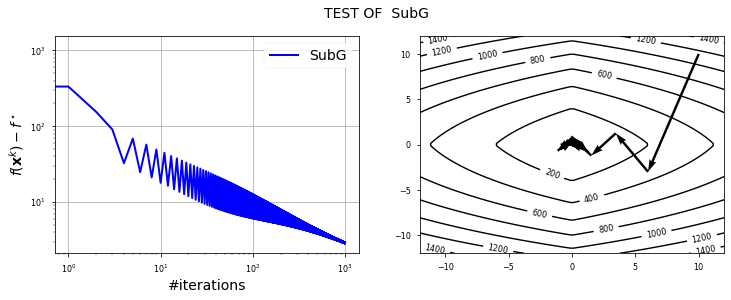

In [5]:
test_composite(SubG)


---

Another, more efficient approach, as we saw in Lecture 8, is to minimize such a function by using proximal gradient algorithms, provided that $g$ is _proximable_ (i.e., its proximal operator is efficient to evaluate). We recall the proximal operator of $g$ as the solution to the following convex problem:
$$
\mathrm{prox}_g(\mathbf{z}) := \mathrm{arg}\min_{\mathbf{y}\in\mathbb{R}^d}\{ g(\mathbf{y}) + \frac{1}{2}\Vert\mathbf{y} - \mathbf{z}\Vert_2^2\}.
$$

#### Question 2 (2 points)

Given $g_{\ell_1}: \mathbb{R}^p \rightarrow \mathbb{R}, \; g_{\ell_1}(\mathbf{x}) :=  \|\mathbf{x}\|_1$,  show that its proximal function can be written as
    $$
    \mathrm{prox}_{\gamma g_{\ell_1}}(\mathbf{z}) = \max(|\mathbf{z}|-\gamma,0) \circ \mathrm{sign}(\mathbf{z}), \; \text{for any }\mathbf{z} \in \mathbb{R}^p,\; \gamma \in \mathbb{R}_+
    $$
			where the operators $\max$, $\mathrm{sign}$ and $\lvert \cdot \lvert$ are applied coordinate-wise to the vector $\mathbf{z}$ and $\circ$ stands for $(\mathbf{x} \circ \mathbf{y})_i = x_i y_i$. Such a regularizer imposes sparsity on the solutions.


For $g_{\ell_1}: \mathbb{R}^p \rightarrow \mathbb{R}, \; g_{\ell_1}(\mathbf{x}) :=  \|\mathbf{x}\|_1$,
$$
\mathrm{prox}_{\gamma g_{\ell_1}}(\mathbf{z}) = \mathrm{arg}\min_{\mathbf{y}\in\mathbb{R}^d}\{ \gamma \|\mathbf{y}\|_1 + \frac{1}{2}\Vert\mathbf{y} - \mathbf{z}\Vert_2^2\}\\
\mathrm{prox}_{\gamma g_{\ell_1}}(\mathbf{z}) = \mathrm{arg}\min_{\mathbf{y}\in\mathbb{R}^d}\{  \sum_{i=1}^p \gamma |y_i| + \frac{1}{2}(y_i - z_i)^2\}\\
$$
Since we have a separable problem we calculate the gradient for each element and take cases based on the sign of $y_i$. $\newline$
For $y_i > 0$ the gradient = $\gamma + y_i - z_i$, which vanishes for $y_i = z_i - \gamma$ for $z_i > \gamma \newline$
For $y_i < 0$ the gradient = $-\gamma + y_i - z_i$, which vanishes for $y_i = z_i + \gamma$ for $z_i < - \gamma \newline$
We thus have $y_i = 0$ for $-\gamma <= z_i <= \gamma$, which represent the values of $z_i$ in between.$\newline$

In Summary we obtain:
$$
    \mathrm{prox}_{\gamma g_{\ell_1}}(\mathbf{z}) = \max(|\mathbf{z}|-\gamma,0) \circ \mathrm{sign}(\mathbf{z}), \; \text{for any }\mathbf{z} \in \mathbb{R}^p,\; \gamma \in \mathbb{R}_+
$$
where the operators $\max$, $\mathrm{sign}$ and $\lvert \cdot \lvert$ are applied coordinate-wise to the vector $\mathbf{z}$ and $\circ$ stands for $(\mathbf{x} \circ \mathbf{y})_i = x_i y_i$.


#### Question 3 (1 point)
 Fill in the function `l1_prox` with the proximal operator of $g_{\ell_1}$.

In [6]:
def l1_prox(gamma, z):
    
    y = [] 

    for zz in z:
        y.append(np.maximum(np.abs(zz)- gamma,0)*np.sign(zz))
    
    return np.array(y)

#### Question 4 (5 points)
 
Using the information in Lecture 7 slide 14 fill in the codes of methods `ISTA`.

Note that for a given function `h`, you can computte $prox_{\gamma h}(\mathbf{x})$ by calling `h.prox(gamma, x)` 

In [7]:
@dataclass
class ISTA_state(OptState):
    x_k: Vector
    alpha: float

In [8]:
def ISTA_update(composite_function, state):
    f, g =  composite_function
    x_k, alpha = state
    
    next_x_k = g.prox(alpha, x_k - alpha*(f.grad(x_k)))
    
    return ISTA_state(next_x_k, alpha)

def ISTA_initialize(composite_function, x_zero):
    f, g = composite_function
    return ISTA_state(x_zero, 1/f.lips_grad)

In [9]:
ISTA = OptAlgorithm(name="ISTA", init_state= ISTA_initialize, state_update=ISTA_update)

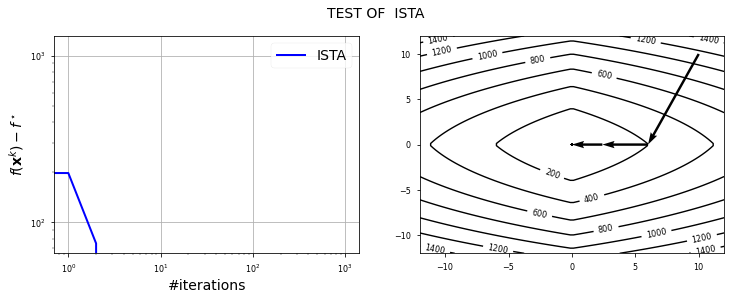

In [10]:
test_composite(ISTA)

#### Question 5  (8 points)

Using the information in Lecture 7, implement `FISTA`.

Adapt it to also handle restarts: You need to implement the so-called __gradient restart condition__ , described in depth in papers such as [this one](http://archive.control.lth.se/media/Staff/PontusGiselsson/publications/gisBoydCDC2014afgm.pdf). Formally, the criterion is given by,
$$\langle \mathbf{y}^{k}-\mathbf{x}^{k+1}, \mathbf{x}^{k+1} - \mathbf{x}^k \rangle > 0,$$
where $k$ is the iteration index. The term $\mathbf{y}^{k}-\mathbf{x}^{k+1}$ can be seen as a gradient, while $\mathbf{x}^{k+1} - \mathbf{x}^k$ is the descent direction of the momentum term. Overall this criterion resets the momentum of FISTA to $0$ when it goes in a bad descent direction. 

In [11]:
@dataclass 
class FISTA_state(OptState):
    x_k: Vector
    y_k: Vector
    t_k: float
    alpha: float

In [12]:
def FISTA_update(composite_function, state):
    f, g = composite_function
    x_k, y_k, t_k, alpha = state
    
    next_x_k = g.prox(alpha, y_k - alpha*f.grad(y_k))
    next_t_k = (1 + (4*t_k**2+1)**0.5)/2
    next_y_k = next_x_k + (t_k - 1)*(next_x_k-x_k)/next_t_k
    
    return FISTA_state(next_x_k, next_y_k, next_t_k, alpha)

def FISTA_initialize(composite_function, x_zero):
    return FISTA_state(x_zero, x_zero, 1.0, 1/composite_function.f.lips_grad)


In [13]:
FISTA = OptAlgorithm(name="FISTA", init_state= FISTA_initialize, state_update=FISTA_update)

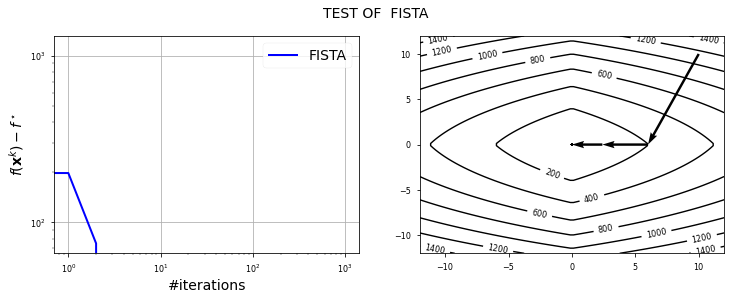

In [14]:
test_composite(FISTA)

# Part 2: Application


We have now implemented multiple methods that can solve composite optimization problems. We will now apply them to an image inpainting problem.


Take a natural image, or better a picture of you, and place it in the same directory as this notebook.

c:\Users\Asus\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


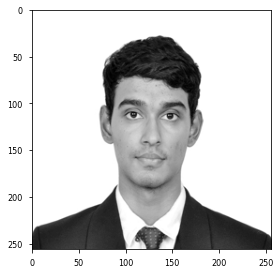

In [15]:
from lib.inpainting import *

image = load("alp.jpg")

With this image in hand, let us subsample it and try to reconstruct the original.

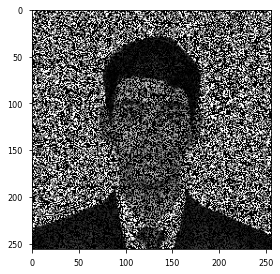

In [16]:
subsampled = show_subsampled(image)

In the following cells we will define the optimization problems we need to solve to perform the reconstruction.

- We provide you with a function `P` that acts like the matrix $\mathbf{P}_{\Omega}$. That is, given a vector `x`, it returns a subsampled vector `P(x)` that corresponds to $\mathbf{P}_{\Omega} \mathbf{x}$. We also give you `P_T` which acts like $\mathbf{P}^\top$.
- We provide you with a function `W` and `W_T` that act like the matrix $\mathbf{W}$ and $\mathbf{W^\top}$ respectively. That is, for a vector `x`, `W(x)` and `W_T(x)` return $\mathbf{W}\mathbf{x}$ and $\mathbf{W^\top}\mathbf{x}$ respectively.

__(a)__ (1 point) Using these provided functions, define the observed variable `b` in the cell below.

In [17]:
from lib.inpainting import P, P_T, W, W_T

x = image.reshape(-1) #flattened image

b = P(x)

__(b)__ (1 point) Now define the function `f_l1` as described earlier in the problem text.

In [18]:
def f_l1(alpha):
    
    bb = b - P(W_T(alpha))
    
    return numpy.linalg.norm(bb)/2

__(c)__ (1 point) Write the gradient of $f_{\ell_1}(\mathbf{\alpha})$.

In [19]:
def grad_f_l1(alpha):

    return -W(P_T(b - P(W_T(alpha))))

__(d)__ (1 points) Find the Lipschitz constant of $\nabla_\mathbf{\alpha} f_{\ell_1}(\mathbf{\alpha})$ analytically and fill it in the cell below. 

$\textbf{Ans.})$ From the definition of $f_{\ell_1}$ we have that $\nabla_\mathbf{\alpha} f_{\ell_1}(\mathbf{\alpha}) = A^T (A\alpha − b)$ where $A = P_{\Omega}W^T.\newline$
Observations : $\newline$
W is unitary since it consists of an orthonormal basis and $P_{Omega}$ is a diagonal matrix with n 1's and 0 for the rest of the diagonal elements, since it only picks n pixels from the vectorized image x.

$$
    |\nabla_\mathbf{\alpha} f_{\ell_1}(\mathbf{\alpha_1}) - \nabla_\mathbf{\alpha} f_{\ell_1}(\mathbf{\alpha_2})| = |A^T (A\alpha_1 − b) - A^T (A\alpha_2 − b)| = |A^TA(\alpha_1 - \alpha_2)| \leq \|A^TA\| |\alpha_1-\alpha_2|
$$
Thus we get that the lipschitz constant (L) for $\nabla_\mathbf{\alpha} f_{\ell_1}(\mathbf{\alpha}) = \|A^TA\|$ (spectral norm). $\newline$ 
$$
L= \text{spectral norm}(WP_{\Omega}^TP_{\Omega}W^T) = \text{spectral norm}(WP_{\Omega}W^T) = 1
$$
L = 1 since the matrix $WP_{\Omega}W^T$ is already in the  form of a eigen value decomposition as W consists of an orthnormal basis and $P_{\Omega}$ is a diagonal matrix with 1 and 0's as its diagonal elements. Spectral norm represents the highest singular value of the matrix $A^TA$ thus we get that L=1.

In [20]:
lips_grad_f_l1 = 1

We have all the necessary ingredients to define the smooth part of our composite objective:

In [21]:
f_l1 = Function(f = f_l1, grad=grad_f_l1, lips_grad = lips_grad_f_l1)

For the non-smooth term, we define a regularizer built around the `l1` function that re-uses the `l1_prox` function you implemented earlier:

In [22]:
l1 = Function(f = lambda x: np.sum(np.abs(x), axis=0), prox=l1_prox)

g_l1 = Regularizer(l1)

In [23]:
composite_objective = CompositeFunction(f=f_l1, g=g_l1)

With the objective defined, we provide you with a function with the following signature:
```python
solve_composite(method: OptAlgorithm, composite_objective: CompositeFunction, lmda: float, max_iterations: int) -> Vector
```

In other words, the function takes an optimization algorithm `method`, a CompositeFunction `composite_objective`, a regularization parameter `lmda` and a number of iterations `max_iterations` and returns a vector which is the last iterate given by the `method`.



In [24]:
from lib.inpainting import solve_composite

__(e)__ (6 points) Using `solve_composite` reconstruct the subsampled image. Recall that the composite problem solves for $\mathbf{\alpha}$ so you need to convert the output back to an image and visualize it.

Set the number of iterations around `1000`, and select a reasonable value for `lmda` or (BONUS) using the function `solve_composite` and the `PSNR` metric, find the best value for `lmda`.

In [26]:
out = solve_composite(FISTA, composite_objective, 1, 1000)
flat_image_out = W_T(out)
image_out = flat_image_out.reshape(256, 256)

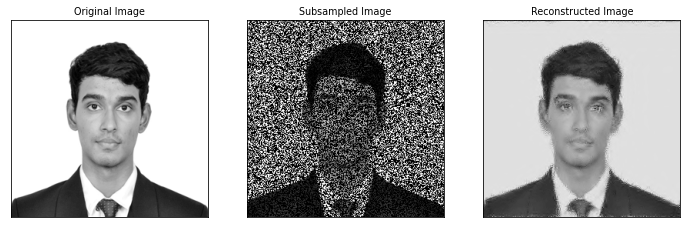

In [27]:
show(true = image, subsampled=subsampled, estimated=image_out)